In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
import json

In [3]:
data = pd.read_csv('origin_data.csv')

In [4]:
total_data = pd.DataFrame({},\
                    columns=['id', 'no', 'prob', 'human_label', 'human_len', 'ai_label', 'ai_len', 'crop_time', 'image_time', 'similarity', 'correct'])

In [5]:
index = 0
for i in data.index:
    meta_dict = json.loads(data.loc[i].payload)

    sum_crop_time = 0
    for image_data in meta_dict['meta']['crop_image']:
        sum_crop_time += image_data['region_attributes']['crop_time']
    
    for image_data in meta_dict['meta']['crop_image']:
        if len(image_data['region_attributes']['label']) == 0:
            continue
        row = dict()
        
        row['id'] = data.loc[i].id
        row['no'] = image_data['shape_attributes']['id']
        row['prob'] = image_data['region_attributes']['prob']
        row['human_label'] = image_data['region_attributes']['label']
        row['human_len'] = int(len(image_data['region_attributes']['label']))
        row['ai_label'] = image_data['region_attributes']['ai_label']
        row['ai_len'] = int(len(image_data['region_attributes']['ai_label']))
        row['crop_time'] = image_data['region_attributes']['crop_time']
        row['image_time'] = image_data['region_attributes']['image_time'] \
                            *(row['crop_time'] / sum_crop_time)
        row['similarity'] = image_data['region_attributes']['similarity']
        row['correct'] = int(image_data['correct'][-1])
        
        total_data.loc[index] = row
        index+=1

In [6]:
features = total_data[['prob', 'human_len', 'ai_len', 'crop_time', 'image_time', 'similarity']]
total_data['correct'] = total_data.apply(lambda row: 0 if row.correct > 0.5 else 1, axis=1)

# 계측지 분석

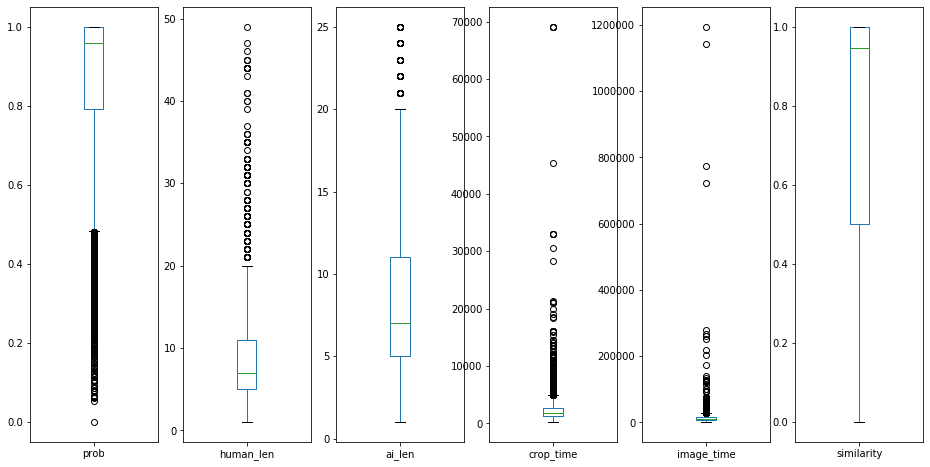

In [7]:
fig, ax = plt.subplots(1, 6, figsize=(16,8))

for i, col in enumerate(features.columns):
    features[col].plot.box(ax=ax[i])

# 이상치 제거 후 확인

In [8]:
total_data = total_data[total_data['human_len'] <= 20]
total_data = total_data[total_data['ai_len'] <= 20]
total_data = total_data[total_data['crop_time'] <= 10000]
total_data = total_data[total_data['image_time'] <= 200000]

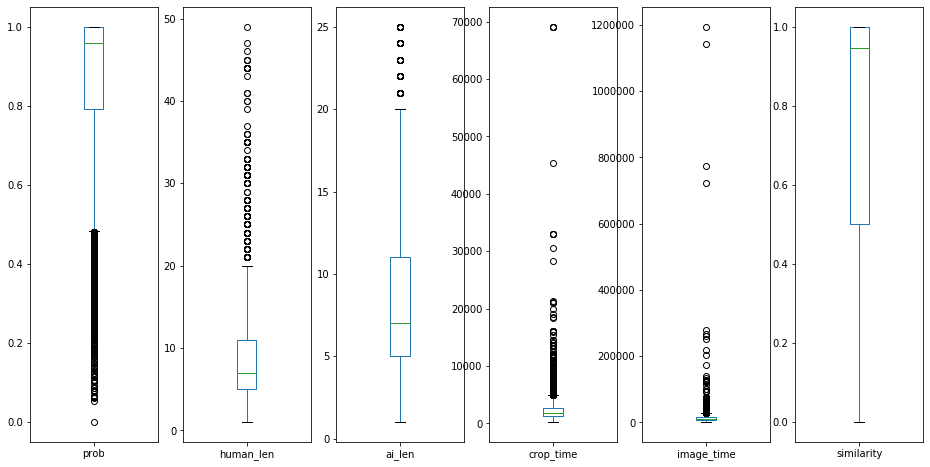

In [9]:
fig, ax = plt.subplots(1, 6, figsize=(16,8))

for i, col in enumerate(features.columns):
    features[col].plot.box(ax=ax[i])

# 정규화

In [10]:
robust = RobustScaler()
total_data[['prob', 'human_len', 'ai_len', 'crop_time', 'image_time', 'similarity']] =\
robust.fit_transform(total_data[['prob', 'human_len', 'ai_len', 'crop_time', 'image_time', 'similarity']])

# 특징과 라벨 추출

In [11]:
features = total_data[['prob', 'human_len', 'ai_len', 'crop_time', 'image_time', 'similarity', 'correct']]

In [12]:
display(features.head())

,prob,human_len,ai_len,crop_time,image_time,similarity,correct
0,0.212430,0.333333,0.4,-0.234585,0.060377,0.121693,1
1,0.120580,0.666667,0.6,0.202693,0.547058,0.000000,1
2,-2.564091,-0.166667,-0.2,-0.391212,-0.113945,-2.433862,1
3,-3.461459,0.666667,0.4,-0.076541,0.236276,-1.156085,1
4,0.212919,0.000000,0.0,0.746988,0.667587,0.121693,0


# BIC를 통해 얻은 회기식 실행

In [13]:
features['pred'] = features.apply(lambda row:\
                                  -0.0632684200437098 * row.prob +\
                                  -0.263687136584231* row.human_len+\
                                  0.212213502241637* row.ai_len+\
                                  -0.0230254681509159* row.crop_time+\
                                  -0.160075973021105*row.similarity+\
                                  0.0853052747319063, axis=1)

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [14]:
# 맞은 것 갯수
len(features[features.correct == (features.pred > 0.5)])

3850

In [15]:
# 정확도
len(features[features.correct == (features.pred > 0.5)]) / len(features)

0.902696365767878

# AIC를 통해 얻은 회기식 실행

In [16]:
features['pred2'] = features.apply(lambda row:\
                                  -0.06331 * row.prob +\
                                  -0.26210 * row.human_len+\
                                  0.21149  * row.ai_len+\
                                  -0.01497 * row.crop_time+\
                                   -0.01099 * row.image_time+\
                                  -0.15965  *row.similarity+\
                                  0.08638, axis=1)

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [17]:
# 맞은 것 갯수
len(features[features.correct == (features.pred2 > 0.5)])

3852

In [18]:
# 정확도
len(features[features.correct == (features.pred2 > 0.5)]) / len(features)

0.9031652989449004

In [21]:
display(features.head())

,prob,human_len,ai_len,crop_time,image_time,similarity,correct,pred,pred2
0,0.212430,0.333333,0.4,-0.234585,0.060377,0.121693,1,0.054776,0.053580
1,0.120580,0.666667,0.6,0.202693,0.547058,0.000000,1,0.024546,0.021860
2,-2.564091,-0.166667,-0.2,-0.391212,-0.113945,-2.433862,1,0.647647,0.645773
3,-3.461459,0.666667,0.4,-0.076541,0.236276,-1.156085,1,0.400224,0.398506
4,0.212919,0.000000,0.0,0.746988,0.667587,0.121693,0,0.035154,0.034953


In [20]:
# 전체를 0으로 예측했을 때 정확도
(len(features) - sum(features.correct)) / len(features)

0.7854630715123095